# Finding optimal hyper parameters for a CNN model

The point of this notebook is to obtain an optimal set of parameters for our CNN model to process time based series data. Specifically, we are processing IoT data from TON a well-kept dataset from The UNSW Group in Canberra, Australia.

The specific dataset being discussed here is the IoT Fridge dataset.



We have pip install mealpy each time because it is not a default python package ,and every time the runtime refreshes; the package is uninstalled.

In [ ]:
%pip install mealpy==3.0.1
%pip install -U scikit-learn
%pip install imbalanced-learn
%pip install matplotlib
%pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.3/386.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 86.7 MB/s eta 0:00:00


Our main libraries used are:

*   Imblearn
*   Pandas
*   Matplot Lib
*   MealPy
*   Numpy
*   SKLearn
*   Tensorflow
*   Time



In [ ]:
import pandas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from imblearn.combine import SMOTETomek
import numpy
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
from mealpy import FloatVar, LCO
import time

# Preparing the Datasets for the CNN Model

We split off the information that indicates whether or not an attack has occured (*label*) and the types of attacks (*type*).
Now there are three dataframes:
  X - all features
  y - attack or not
  y_type - type of attack

We split again into test and train data sets and include some randomness.
**Reset_index** drops the indexes from these new dataframes.
Next, we encode the text data, add another randomness, and scale all dataframes. The X dataframe is reshaped.

In [ ]:
#Uncomment for local use
#raw_data = pandas.read_csv('../../Train_Test_IoT_dataset/Train_Test_IoT_Fridge.csv')
#Uncomment for Google Colab
raw_data = pandas.read_csv('Train_Test_IoT_Fridge.csv')
X = raw_data.drop(columns=['label','type'])
y = raw_data['label']
y_type = raw_data['type']

In [ ]:
# Binary
X_train, X_testsplit, y_train, y_testsplit = train_test_split(X, y, test_size=0.2, random_state=777)
# Binary validation
X_test, X_validation, y_test, y_validation = train_test_split(X_testsplit, y_testsplit, test_size=0.5, random_state=777)

#drop index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X_validation = X_validation.reset_index(drop=True)
y_validation = y_validation.reset_index(drop=True)

In [ ]:
encoder = OrdinalEncoder()
label_encoder = LabelEncoder()
X_train_encode = encoder.fit_transform(X_train)
X_test_encode = encoder.fit_transform(X_test)
y_train_encode = label_encoder.fit_transform(y_train)
y_test_encode = label_encoder.fit_transform(y_test)
X_validation_encode = encoder.fit_transform(X_validation)
y_validation_encode = label_encoder.fit_transform(y_validation)

In [ ]:
smotetomek = SMOTETomek(random_state=777)
X_rebalance, y_rebalance = smotetomek.fit_resample(X_train_encode, y_train_encode)

In [ ]:
scaler = StandardScaler()
X_rebalance = scaler.fit_transform(X_rebalance)
X_test_encode = scaler.transform(X_test_encode)

X_validation_encode = scaler.transform(X_validation_encode)

In [ ]:
X_rebalance = X_rebalance.reshape(X_rebalance.shape[0], X_rebalance.shape[1], 1)
X_test_encode = X_test_encode.reshape(X_test_encode.shape[0], X_test_encode.shape[1], 1)

X_validation_encode = X_validation_encode.reshape(X_validation_encode.shape[0], X_validation_encode.shape[1], 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2, 50)          │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 50)          │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,633 (248.57 KB)

 Trainable params: 63,533 (248.18 KB)

 Non-trainable params: 100 (400.00 B)

Epoch 1/70
626/626 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5113 - loss: 0.6927 - val_accuracy: 0.4678 - val_loss: 0.6928
Epoch 2/70
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5159 - loss: 0.6926 - val_accuracy: 0.5900 - val_loss: 0.6924
Epoch 3/70
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5141 - loss: 0.6924 - val_accuracy: 0.5912 - val_loss: 0.6921
Epoch 4/70
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5109 - loss: 0.6929 - val_accuracy: 0.6165 - val_loss: 0.6919
Epoch 5/70
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5228 - loss: 0.6917 - val_accuracy: 0.6140 - val_loss: 0.6915
Epoch 6/70
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5249 - loss: 0.6916 - val_accuracy: 0.6733 - val_loss: 0.6916
Epoch 7/70
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5241 - loss: 0.6916 - val_accuracy: 0.6696 - val_loss: 0.6914
Epoch 8/70
626/626 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5315 - loss: 0.6909 - val_accuracy: 0.

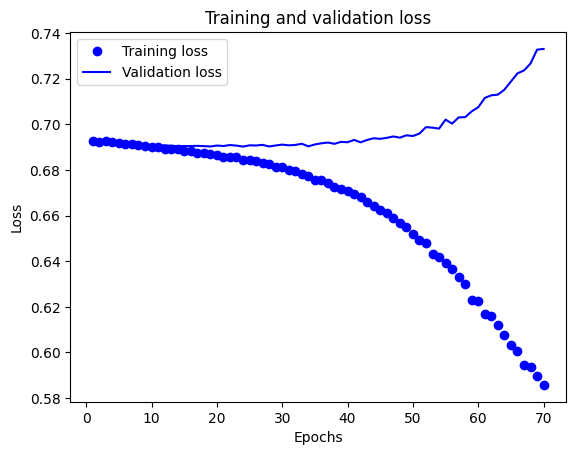

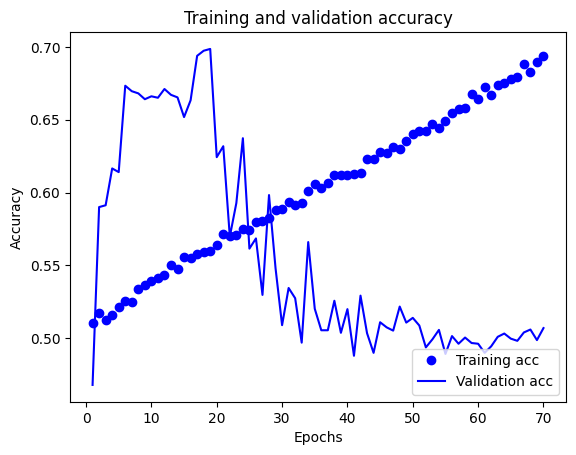


Classification Report
              precision    recall  f1-score   support

           0       0.43      0.88      0.57      1518
           1       0.79      0.27      0.41      2476

    accuracy                           0.50      3994
   macro avg       0.61      0.58      0.49      3994
weighted avg       0.65      0.50      0.47      3994


Confusion Matrix
[[1337  181]
 [1798  678]]


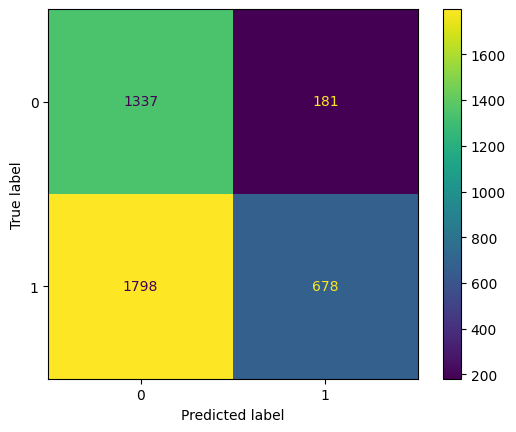

Time taken: 212.9541 seconds


In [ ]:
start_time_1 = time.perf_counter()
with tensorflow.device('/device:GPU:0'):
  # CNN model detection
  # https://keras.io/api/layers/activations/#softmax-function
  detection_model = tensorflow.keras.Sequential([
      tensorflow.keras.layers.Input(shape=(X_rebalance.shape[1],X_rebalance.shape[2])),
      tensorflow.keras.layers.Conv1D(filters=50, kernel_size=3, activation='sigmoid'),
      tensorflow.keras.layers.MaxPooling1D(pool_size=2),
      tensorflow.keras.layers.Dropout(0.3),
      tensorflow.keras.layers.BatchNormalization(),
      tensorflow.keras.layers.LSTM(64),
      tensorflow.keras.layers.Flatten(),
      # 1 layer
      tensorflow.keras.layers.Dense(512, activation='relu'),
      tensorflow.keras.layers.Dropout(0.5),
      # either attack or normal
      tensorflow.keras.layers.Dense(1, activation='sigmoid')
  ])

  detection_model.summary()
  # https://keras.io/api/losses/probabilistic_losses/#probabilistic-losses
  sgd = tensorflow.keras.optimizers.SGD(learning_rate=0.001)
  detection_model.compile(optimizer=sgd,
                loss=tensorflow.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])

  history = detection_model.fit(X_rebalance, y_rebalance, batch_size=64, epochs=70, validation_data=(X_validation_encode, y_validation_encode))
  test_loss, test_acc = detection_model.evaluate(X_test_encode, y_test_encode)

  # Make predictions
  prediction = detection_model.predict(X_test_encode)
  print(prediction)
  attack_prediction = numpy.where(prediction > 0.5, 1, 0)
  print(attack_prediction)
  print(y_test)

  # Evaluate the model
  print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}\n")
  # https://www.tensorflow.org/tutorials/keras/text_classification for training and validation loss and accuracy
  history_dict = history.history
  # print(history_dict.keys())
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  print("\n")

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()

  print("\nClassification Report")
  print(classification_report(y_test, attack_prediction))

  print("\nConfusion Matrix")
  print(confusion_matrix(y_test, attack_prediction))
  ConfusionMatrixDisplay.from_predictions(y_test, attack_prediction)
  plt.show()

end_time1 = time.perf_counter()
print(f"Time taken: {end_time1 - start_time_1:0.4f} seconds")

# Optimizing the model
Instead of looking at random number ranges for learning rates, filters, and hidden units, we have encoded specific values.

The hyper parameters we are attempting to optimize are:

*   Batch Size
*   Activation Functions
*   Learning Rates
*   Filters
*   Hidden Units


The base CNN model we made is ingested into *objective_function*.
  This is where our hyper parameters are being considered.
  It returns the Accuracy of that particular iteration.
**LB** and **UB** is set according to the list given above.



In [ ]:
BATCH_ENCODER = LabelEncoder()
BATCH_ENCODER.fit([32, 64, 128])

#act encoder --> Which activation function should be used?
ACT_ENCODER = LabelEncoder()
ACT_ENCODER.fit(['softmax', 'softplus', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear'])

#Learning Rate encoder
LR_ENCODER = LabelEncoder()
LR_ENCODER.fit([0.0005, 0.001, 0.005, 0.01, 0.05, 0.1])


#Filter encoder
FILTER_ENCODER = LabelEncoder()
FILTER_ENCODER.fit([25, 50, 75])

#Hidden Units encoder
HIDDEN_ENCODER = LabelEncoder()
HIDDEN_ENCODER.fit([400, 512, 640])

def objective_function(params):
  '''RULES:
      Batch Size - 32, 64, 128
      Activation - softmax, softplus, relu, tanh, sigmoid, hard_sigmoid, linear
      Learning Rate - 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1
      Filters - 25, 50, 75
      Hidden Units - 400, 512, 640
      Dense Layers - 5, 8, 10
  '''
  batch_size = BATCH_ENCODER.inverse_transform([int(params[0])])[0]
  activation = ACT_ENCODER.inverse_transform([int(params[1])])[0]
  learning_rate = LR_ENCODER.inverse_transform([int(params[2])])[0]
  filter = FILTER_ENCODER.inverse_transform([int(params[3])])[0]
  hidden_units = HIDDEN_ENCODER.inverse_transform([int(params[4])])[0]

  model = tensorflow.keras.Sequential()
  model.add(tensorflow.keras.layers.Input(shape=(X_rebalance.shape[1], X_rebalance.shape[2]))),
  model.add(tensorflow.keras.layers.Conv1D(filters=filter, kernel_size=3, activation='sigmoid')),
  model.add(tensorflow.keras.layers.MaxPooling1D(pool_size=2)),
  model.add(tensorflow.keras.layers.Dropout(0.3)),
  model.add(tensorflow.keras.layers.BatchNormalization()),
  model.add(tensorflow.keras.layers.LSTM(64)),
  model.add(tensorflow.keras.layers.Flatten()),
  model.add(tensorflow.keras.layers.Dense(int(hidden_units), activation=activation)),
  model.add(tensorflow.keras.layers.Dropout(0.5)),
  model.add(tensorflow.keras.layers.Dense(1, activation='sigmoid'))

  optimizer = tensorflow.keras.optimizers.SGD(learning_rate=learning_rate)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

  history = model.fit(X_rebalance, y_rebalance, batch_size=batch_size, epochs=15, validation_data=(X_validation_encode, y_validation_encode), verbose=0)
  min_validation_accuracy = 1-history.history['val_accuracy'][-1]
  print(f"Accuracy {min_validation_accuracy}")
  return min_validation_accuracy

LB = [0, 0, 0, 0, 0]
UB = [2.99, 6.99, 5.99, 2.99, 2.99]

problem_dict = {
    "obj_func": objective_function,
    "bounds": FloatVar(lb=LB, ub=UB),
    "minmax": "min",
    "verbose": True
}

model = LCO.OriginalLCO(epoch=15, pop_size=20, r1=2.35)
g_best = model.solve(problem_dict)
print(f"Solution: {g_best.solution}, Fitness: {g_best.target.fitness}")
print(f"Solution: {model.g_best.solution}, Fitness: {model.g_best.target.fitness}")
model.history.save_global_objectives_chart(filename="hello/goc")
model.history.save_local_objectives_chart(filename="hello/loc")

model.history.save_global_best_fitness_chart(filename="hello/gbfc")
model.history.save_local_best_fitness_chart(filename="hello/lbfc")

model.history.save_runtime_chart(filename="hello/rtc")

model.history.save_exploration_exploitation_chart(filename="hello/eec")

model.history.save_diversity_chart(filename="hello/dc")

INFO:mealpy.human_based.LCO.OriginalLCO:Solving single objective optimization problem.


Accuracy 0.011764705181121826
Accuracy 0.4996245503425598
Accuracy 0.3842303156852722
Accuracy 0.3842303156852722
Accuracy 0.6157697141170502
Accuracy 0.46232789754867554
Accuracy 0.03354191780090332
Accuracy 0.6157697141170502
Accuracy 0.6157697141170502
Accuracy 0.5001251697540283
Accuracy 0.6157697141170502
Accuracy 0.09486860036849976
Accuracy 0.3842303156852722
Accuracy 0.46958696842193604
Accuracy 0.15844804048538208
Accuracy 0.7188986241817474
Accuracy 0.45231539011001587
Accuracy 0.3842303156852722
Accuracy 0.6157697141170502
Accuracy 0.23053818941116333
Accuracy 0.6157697141170502
Accuracy 0.21752190589904785
Accuracy 0.6157697141170502
Accuracy 0.13366711139678955
Accuracy 0.3234042525291443
Accuracy 0.6157697141170502
Accuracy 0.1294117569923401
Accuracy 0.6157697141170502
Accuracy 0.13166457414627075
Accuracy 0.481101393699646
Accuracy 0.27809762954711914
Accuracy 0.23304128646850586
Accuracy 0.45957446098327637
Accuracy 0.23304128646850586
Accuracy 0.6157697141170502
Accur

INFO:mealpy.human_based.LCO.OriginalLCO:>>>Problem: P, Epoch: 1, Current best: 0.03354191780090332, Global best: 0.03354191780090332, Runtime: 672.50731 seconds


Accuracy 0.6157697141170502
Accuracy 0.15919899940490723
Accuracy 0.1789737343788147
Accuracy 0.0693366527557373
Accuracy 0.5103879868984222
Accuracy 0.2623279094696045
Accuracy 0.3842303156852722
Accuracy 0.4723404049873352
Accuracy 0.06307882070541382
Accuracy 0.31113892793655396
Accuracy 0.5344180166721344
Accuracy 0.09787231683731079
Accuracy 0.3842303156852722
Accuracy 0.6157697141170502
Accuracy 0.3842303156852722
Accuracy 0.1536921262741089
Accuracy 0.10137671232223511
Accuracy 0.09436798095703125
Accuracy 0.13366711139678955
Accuracy 0.23304128646850586


INFO:mealpy.human_based.LCO.OriginalLCO:>>>Problem: P, Epoch: 2, Current best: 0.03354191780090332, Global best: 0.03354191780090332, Runtime: 569.89548 seconds


Accuracy 0.25281602144241333
Accuracy 0.6157697141170502
Accuracy 0.20725905895233154
Accuracy 0.1654568314552307
Accuracy 0.13316643238067627
Accuracy 0.0838547945022583
Accuracy 0.48460572957992554
Accuracy 0.1406758427619934
Accuracy 0.1309136152267456
Accuracy 0.3992490768432617
Accuracy 0.6157697141170502
Accuracy 0.0863579511642456
Accuracy 0.14392989873886108
Accuracy 0.13366711139678955
Accuracy 0.34167706966400146
Accuracy 0.6157697141170502
Accuracy 0.3842303156852722
Accuracy 0.3011264204978943
Accuracy 0.3521902561187744
Accuracy 0.6157697141170502


INFO:mealpy.human_based.LCO.OriginalLCO:>>>Problem: P, Epoch: 3, Current best: 0.03354191780090332, Global best: 0.03354191780090332, Runtime: 529.73390 seconds


Accuracy 0.3306633234024048
Accuracy 0.13366711139678955
Accuracy 0.13366711139678955
Accuracy 0.07384228706359863
Accuracy 0.5078848600387573
Accuracy 0.012515664100646973
Accuracy 0.2673341631889343
Accuracy 0.11113893985748291
Accuracy 0.6157697141170502
Accuracy 0.2991238832473755
Accuracy 0.6157697141170502
Accuracy 0.20525658130645752
Accuracy 0.6157697141170502
Accuracy 0.21301627159118652
Accuracy 0.31163954734802246
Accuracy 0.2648310661315918
Accuracy 0.13366711139678955
Accuracy 0.6157697141170502
Accuracy 0.3842303156852722
Accuracy 0.3842303156852722


INFO:mealpy.human_based.LCO.OriginalLCO:>>>Problem: P, Epoch: 4, Current best: 0.012515664100646973, Global best: 0.012515664100646973, Runtime: 610.84055 seconds


Accuracy 0.1309136152267456
Accuracy 0.49486857652664185
Accuracy 0.22578221559524536
Accuracy 0.08310389518737793
Accuracy 0.2846057415008545
Accuracy 0.13266581296920776
Accuracy 0.5431789755821228
Accuracy 0.6157697141170502
Accuracy 0.11664581298828125
Accuracy 0.13366711139678955
Accuracy 0.12891113758087158
Accuracy 0.48035043478012085
Accuracy 0.09261578321456909
Accuracy 0.09812265634536743
Accuracy 0.18498122692108154
Accuracy 0.2953692078590393
Accuracy 0.09461826086044312
Accuracy 0.3842303156852722
Accuracy 0.498623251914978
Accuracy 0.4951189160346985


INFO:mealpy.human_based.LCO.OriginalLCO:>>>Problem: P, Epoch: 5, Current best: 0.012515664100646973, Global best: 0.012515664100646973, Runtime: 671.91744 seconds


Accuracy 0.2322903871536255
Accuracy 0.2690863609313965
Accuracy 0.44780975580215454
Accuracy 0.6157697141170502
Accuracy 0.09612017869949341
Accuracy 0.13942426443099976
Accuracy 0.1376720666885376
Accuracy 0.13366711139678955
Accuracy 0.13366711139678955
Accuracy 0.5394242703914642
Accuracy 0.6157697141170502
Accuracy 0.13366711139678955
Accuracy 0.0688360333442688
Accuracy 0.0538172721862793
Accuracy 0.30337923765182495
Accuracy 0.09436798095703125
Accuracy 0.6007509529590607
Accuracy 0.3511889576911926
Accuracy 0.13366711139678955
Accuracy 0.21326661109924316


INFO:mealpy.human_based.LCO.OriginalLCO:>>>Problem: P, Epoch: 6, Current best: 0.012515664100646973, Global best: 0.012515664100646973, Runtime: 649.91232 seconds


Accuracy 0.4971213936805725
Accuracy 0.3046308159828186
Accuracy 0.13366711139678955
Accuracy 0.4635794758796692
Accuracy 0.3842303156852722
Accuracy 0.4893617033958435
Accuracy 0.025782227516174316
Accuracy 0.03629535436630249
Accuracy 0.5266583263874054
Accuracy 0.1914893388748169
Accuracy 0.5128911137580872
Accuracy 0.09461826086044312
Accuracy 0.28285354375839233
Accuracy 0.09261578321456909
Accuracy 0.46958696842193604
Accuracy 0.13216519355773926
Accuracy 0.3156445622444153
Accuracy 0.11138921976089478
Accuracy 0.4926157593727112
Accuracy 0.2818523049354553


INFO:mealpy.human_based.LCO.OriginalLCO:>>>Problem: P, Epoch: 7, Current best: 0.012515664100646973, Global best: 0.012515664100646973, Runtime: 670.04872 seconds


Accuracy 0.0911138653755188
Accuracy 0.12215268611907959
Accuracy 0.15544432401657104
Accuracy 0.13366711139678955
Accuracy 0.1256570816040039
Accuracy 0.17421776056289673
Accuracy 0.13366711139678955
Accuracy 0.16720902919769287
Accuracy 0.12140172719955444
Accuracy 0.09887361526489258
Accuracy 0.13366711139678955
Accuracy 0.48035043478012085
Accuracy 0.1329161524772644
Accuracy 0.6055068969726562
Accuracy 0.13366711139678955
Accuracy 0.14618271589279175
Accuracy 0.08285355567932129
Accuracy 0.2818523049354553
Accuracy 0.2152690887451172
Accuracy 0.6157697141170502


INFO:mealpy.human_based.LCO.OriginalLCO:>>>Problem: P, Epoch: 8, Current best: 0.012515664100646973, Global best: 0.012515664100646973, Runtime: 569.94354 seconds


Accuracy 0.5797246694564819
Accuracy 0.023028790950775146
Accuracy 0.023028790950775146
Accuracy 0.22102630138397217
Accuracy 0.13366711139678955
Accuracy 0.0025031566619873047
Accuracy 0.06808513402938843
Accuracy 0.13016271591186523
Accuracy 0.052816033363342285
Accuracy 0.3842303156852722
Accuracy 0.025531888008117676
Accuracy 0.08485609292984009
Accuracy 0.6152690947055817
Accuracy 0.6015018820762634
Accuracy 0.1639549732208252
Accuracy 0.12690865993499756
Accuracy 0.3842303156852722
Accuracy 0.6157697141170502
Accuracy 0.4923654794692993
Accuracy 0.30863577127456665


INFO:mealpy.human_based.LCO.OriginalLCO:>>>Problem: P, Epoch: 9, Current best: 0.0025031566619873047, Global best: 0.0025031566619873047, Runtime: 655.81124 seconds


Accuracy 0.531414270401001
Accuracy 0.046808481216430664
Accuracy 0.13316643238067627
Accuracy 0.4941176176071167
Accuracy 0.14042550325393677
Accuracy 0.29511892795562744
Accuracy 0.13366711139678955
Accuracy 0.48035043478012085
Accuracy 0.08160197734832764
Accuracy 0.09511888027191162
Accuracy 0.3842303156852722
Accuracy 0.16470587253570557
Accuracy 0.11564457416534424
Accuracy 0.5639549493789673
Accuracy 0.18272840976715088
Accuracy 0.11113893985748291
Accuracy 0.6157697141170502
Accuracy 0.32615768909454346
Accuracy 0.3842303156852722
Accuracy 0.13366711139678955


INFO:mealpy.human_based.LCO.OriginalLCO:>>>Problem: P, Epoch: 10, Current best: 0.0025031566619873047, Global best: 0.0025031566619873047, Runtime: 566.68170 seconds


Accuracy 0.13366711139678955
Accuracy 0.10963702201843262
Accuracy 0.6157697141170502
Accuracy 0.08035045862197876
Accuracy 0.10012513399124146
Accuracy 0.5326658189296722
Accuracy 0.17346686124801636
Accuracy 0.13366711139678955
Accuracy 0.13366711139678955
Accuracy 0.12215268611907959
Accuracy 0.07684606313705444
Accuracy 0.09586983919143677
Accuracy 0.18498122692108154
Accuracy 0.13366711139678955
Accuracy 0.12715893983840942
Accuracy 0.08560699224472046
Accuracy 0.38147681951522827
Accuracy 0.15819776058197021
Accuracy 0.3842303156852722
Accuracy 0.1246558427810669


INFO:mealpy.human_based.LCO.OriginalLCO:>>>Problem: P, Epoch: 11, Current best: 0.0025031566619873047, Global best: 0.0025031566619873047, Runtime: 637.38447 seconds


Accuracy 0.6157697141170502
Accuracy 0.13366711139678955
Accuracy 0.1158948540687561
Accuracy 0.36145180463790894
Accuracy 0.3842303156852722
Accuracy 0.11714643239974976
Accuracy 0.5116395354270935
Accuracy 0.284105122089386
Accuracy 0.3842303156852722
Accuracy 0.07534420490264893
Accuracy 0.03804755210876465
Accuracy 0.6157697141170502
Accuracy 0.3842303156852722
Accuracy 0.3842303156852722
Accuracy 0.13366711139678955
Accuracy 0.19374215602874756
Accuracy 0.6157697141170502
Accuracy 0.00275343656539917
Accuracy 0.6157697141170502
Accuracy 0.6055068969726562


INFO:mealpy.human_based.LCO.OriginalLCO:>>>Problem: P, Epoch: 12, Current best: 0.0025031566619873047, Global best: 0.0025031566619873047, Runtime: 672.59893 seconds


Accuracy 0.06182730197906494
Accuracy 0.6157697141170502
Accuracy 0.21952438354492188
Accuracy 0.13266581296920776
Accuracy 0.532415509223938
Accuracy 0.13366711139678955
Accuracy 0.5436795949935913
Accuracy 0.13366711139678955
Accuracy 0.10638296604156494
Accuracy 0.6090112626552582
Accuracy 0.3842303156852722
Accuracy 0.13366711139678955
Accuracy 0.13366711139678955
Accuracy 0.42903631925582886
Accuracy 0.13366711139678955
Accuracy 0.2943679690361023
Accuracy 0.11289113759994507
Accuracy 0.13366711139678955
Accuracy 0.13366711139678955
Accuracy 0.23654568195343018


INFO:mealpy.human_based.LCO.OriginalLCO:>>>Problem: P, Epoch: 13, Current best: 0.0025031566619873047, Global best: 0.0025031566619873047, Runtime: 678.37593 seconds


Accuracy 0.6157697141170502
Accuracy 0.07209008932113647
Accuracy 0.5464330315589905
Accuracy 0.6110137701034546
Accuracy 0.48035043478012085
Accuracy 0.4856070280075073
Accuracy 0.13366711139678955
Accuracy 0.4991239309310913
Accuracy 0.4475594758987427
Accuracy 0.1639549732208252
Accuracy 0.13366711139678955
Accuracy 0.26508134603500366
Accuracy 0.3842303156852722
Accuracy 0.5086357891559601
Accuracy 0.13316643238067627
Accuracy 0.14392989873886108
Accuracy 0.504380464553833
Accuracy 0.29361701011657715
Accuracy 0.07484352588653564
Accuracy 0.4067584276199341


INFO:mealpy.human_based.LCO.OriginalLCO:>>>Problem: P, Epoch: 14, Current best: 0.0025031566619873047, Global best: 0.0025031566619873047, Runtime: 722.76153 seconds


Accuracy 0.6157697141170502
Accuracy 0.1722152829170227
Accuracy 0.30763453245162964
Accuracy 0.1444305181503296
Accuracy 0.13366711139678955
Accuracy 0.13366711139678955
Accuracy 0.1314142942428589
Accuracy 0.10513138771057129
Accuracy 0.16745930910110474
Accuracy 0.48610764741897583
Accuracy 0.13366711139678955
Accuracy 0.30037546157836914
Accuracy 0.10838550329208374
Accuracy 0.47359198331832886
Accuracy 0.6157697141170502
Accuracy 0.17246556282043457
Accuracy 0.1712140440940857
Accuracy 0.5083854794502258
Accuracy 0.13992488384246826
Accuracy 0.18798500299453735


INFO:mealpy.human_based.LCO.OriginalLCO:>>>Problem: P, Epoch: 15, Current best: 0.0025031566619873047, Global best: 0.0025031566619873047, Runtime: 549.34474 seconds


Accuracy 0.12040048837661743
Solution: [2.94456717 5.25192514 5.94848902 0.65928902 1.55290638], Fitness: 0.0025031566619873047
Solution: [2.94456717 5.25192514 5.94848902 0.65928902 1.55290638], Fitness: 0.0025031566619873047


Solution: [2.94456717 5.25192514 5.94848902 0.65928902 1.55290638], Fitness: 0.0025031566619873047

Batch Size - 32, 64, **128**

Activation - softmax, softplus, relu, tanh, sigmoid, **hard_sigmoid**, linear

Learning Rate - 0.0005, 0.001, 0.005, 0.01, 0.05, **0.1**

Filters - **25**, 50, 75

Hidden Units - 400, **512**, 640

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2, 25)          │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 25)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 25)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 25)          │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,033 (222.79 KB)

 Trainable params: 56,983 (222.59 KB)

 Non-trainable params: 50 (200.00 B)

Epoch 1/70
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.4960 - loss: 1.4303 - val_accuracy: 0.6158 - val_loss: 0.8589
Epoch 2/70
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5054 - loss: 1.3540 - val_accuracy: 0.3842 - val_loss: 1.0630
Epoch 3/70
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4966 - loss: 1.3861 - val_accuracy: 0.6158 - val_loss: 0.9029
Epoch 4/70
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5017 - loss: 1.3250 - val_accuracy: 0.3842 - val_loss: 1.5656
Epoch 5/70
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5030 - loss: 1.2942 - val_accuracy: 0.6158 - val_loss: 0.8234
Epoch 6/70
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4985 - loss: 1.2950 - val_accuracy: 0.3842 - val_loss: 1.3753
Epoch 7/70
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4975 - loss: 1.2588 - val_accuracy: 0.6158 - val_loss: 1.0565
Epoch 8/70
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5018 - loss: 1.1910 - val_accuracy: 0.

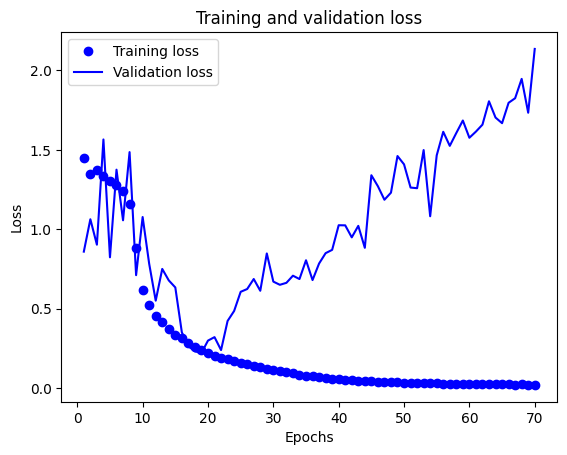

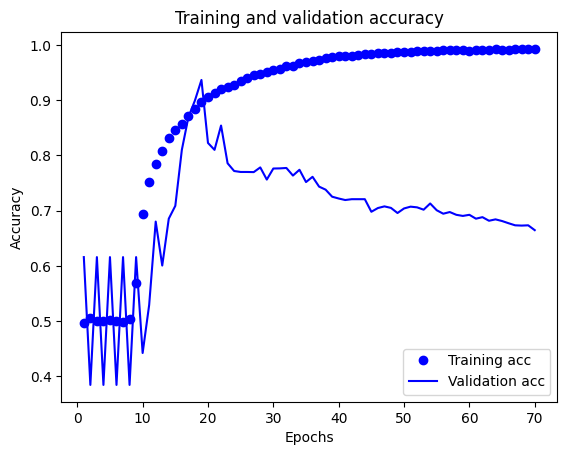


Classification Report
              precision    recall  f1-score   support

           0       1.00      0.12      0.22      1518
           1       0.65      1.00      0.79      2476

    accuracy                           0.67      3994
   macro avg       0.83      0.56      0.50      3994
weighted avg       0.78      0.67      0.57      3994


Confusion Matrix
[[ 189 1329]
 [   0 2476]]


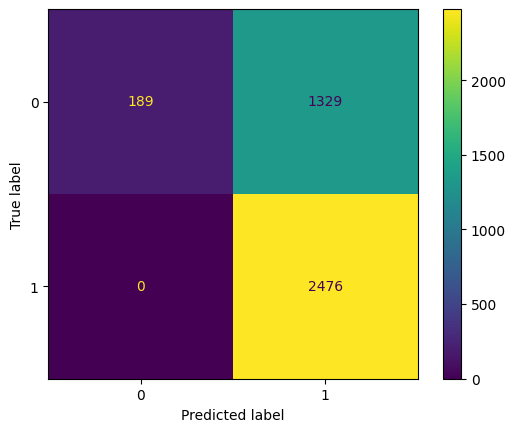

Time taken: 117.7243 seconds


In [ ]:
start_time_2 = time.perf_counter()
with tensorflow.device('/device:GPU:0'):
  # CNN model detection
  # https://keras.io/api/layers/activations/#softmax-function
  detection_model = tensorflow.keras.Sequential([
      tensorflow.keras.layers.Input(shape=(X_rebalance.shape[1],X_rebalance.shape[2])),
      tensorflow.keras.layers.Conv1D(filters=25, kernel_size=3, activation='sigmoid'),
      tensorflow.keras.layers.MaxPooling1D(pool_size=2),
      tensorflow.keras.layers.Dropout(0.3),
      tensorflow.keras.layers.BatchNormalization(),
      tensorflow.keras.layers.LSTM(64),
      tensorflow.keras.layers.Flatten(),
      # 1 layer
      tensorflow.keras.layers.Dense(512, activation='hard_sigmoid'),
      tensorflow.keras.layers.Dropout(0.5),
      # either attack or normal
      tensorflow.keras.layers.Dense(1, activation='sigmoid')
  ])

  detection_model.summary()
  # https://keras.io/api/losses/probabilistic_losses/#probabilistic-losses
  sgd = tensorflow.keras.optimizers.SGD(learning_rate=0.1)
  detection_model.compile(optimizer=sgd,
                loss=tensorflow.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])

  history = detection_model.fit(X_rebalance, y_rebalance, batch_size=128, epochs=70, validation_data=(X_validation_encode, y_validation_encode))
  test_loss, test_acc = detection_model.evaluate(X_test_encode, y_test_encode)

  # Make predictions
  prediction = detection_model.predict(X_test_encode)
  print(prediction)
  attack_prediction = numpy.where(prediction > 0.5, 1, 0)
  print(attack_prediction)
  print(y_test)

  # Evaluate the model
  print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}\n")
  # https://www.tensorflow.org/tutorials/keras/text_classification for training and validation loss and accuracy
  history_dict = history.history
  # print(history_dict.keys())
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  print("\n")

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()

  print("\nClassification Report")
  print(classification_report(y_test, attack_prediction))

  print("\nConfusion Matrix")
  print(confusion_matrix(y_test, attack_prediction))
  ConfusionMatrixDisplay.from_predictions(y_test, attack_prediction)
  plt.show()

end_time2 = time.perf_counter()
print(f"Time taken: {end_time2 - start_time_2:0.4f} seconds")